In [1]:
import os
from glob import glob
from pathlib import Path

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize_angles_2pi,
    open_file,
    cut_jumps
    )

DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'preprocessed_dataset'

# Preprocessing

In [2]:
## Sequence of preproc:
# 1. open files
# 2. cut_jumps
# 3. rescale x and y coords to fit area size 
# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
# 5. resample to required dt
# 6. add angles, delta_angles, step len, 
# 7. save to .csv? to h5?

In [2]:
# 1. open files
dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
datasets = {}
for nam in dataset_names:
    k = Path(nam).stem
    v = open_file(nam, show=False)
    datasets[k] = v

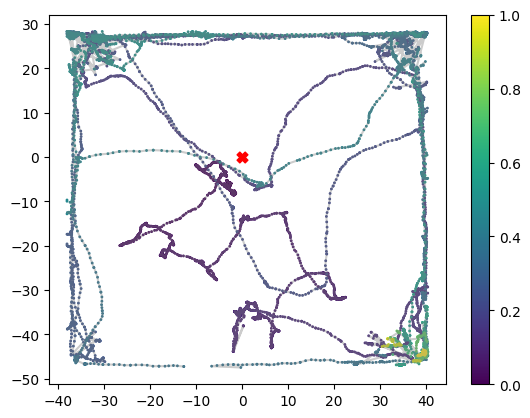

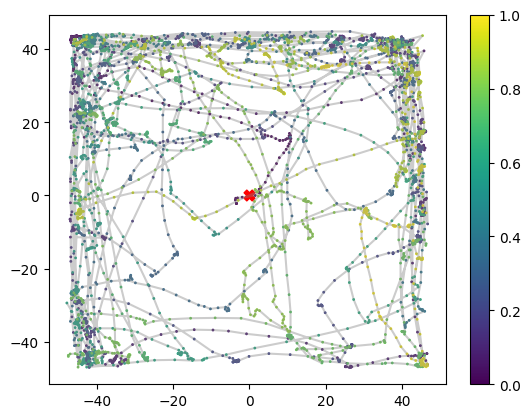

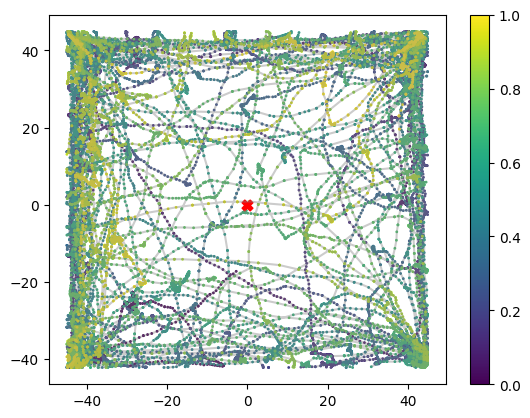

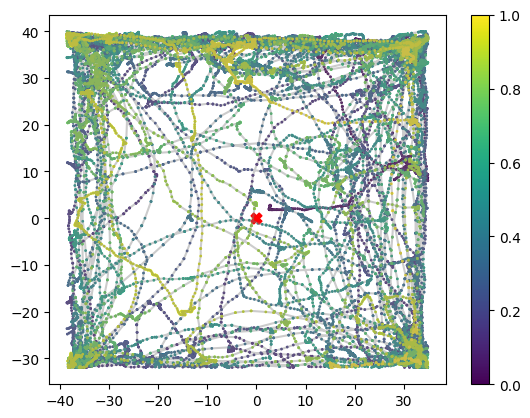

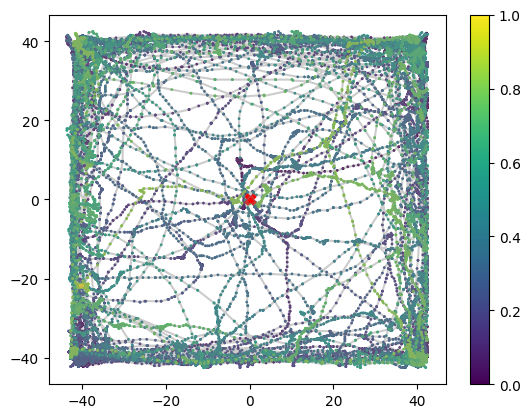

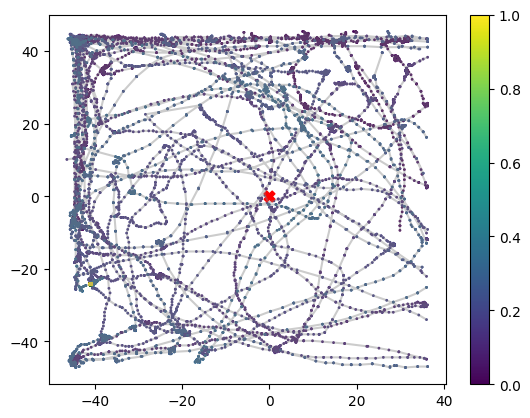

In [3]:
# 2. cut_jumps
tr11 = datasets['Trace_1.1']  # TODO: params to config
tr12 = datasets['Trace_1.2']  
tr2 = datasets['Trace_2']
tr5 = datasets['Trace_5']

tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6)
tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47)
tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2)
tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32)
tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7)
tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3)

In [4]:
dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

In [5]:
# 3. rescale x and y coords to fit area size 
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

AREA_SIZE = [-40, 40]
rescaled_dfs_dict = {}
for k, df in dfs_dict.items():
    df = df.dropna()
    rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    df.loc[:, 'x'] = rescaled_x
    df.loc[:, 'y'] = rescaled_y

    rescaled_dfs_dict[k] = df

In [6]:
# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # 3. Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, df
    
DROP_THRESHOLD = 5
dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135,  # TODO: to configs
                 'tr4': 0.035,  'tr5': 0.035, 'tr6': 0.035, 'tr7': 0.035,
                 'tr91': 0.035, 'tr92': 0.035}

subtraj_dfs_dict = {}
for k, df in rescaled_dfs_dict.items():
    # if k == 'tr3':
    #     print(df)
    k, df_subtraj= divide_traj_by_nans(df, k, dt_threshold=dt_thresholds[k],
                                       traj_drop_threshold=DROP_THRESHOLD)
    subtraj_dfs_dict[k] = df_subtraj  # list of dfs

In [13]:
# 5. resample to required dt
def resample_data_to_larger_timestep(df, original_dt, new_dt):
    from scipy.signal import resample

    num_original_points = df.shape[0]
    duration = num_original_points * original_dt
    num_new_points = int(duration / new_dt)
    
    resampled_dfnp = resample(df.to_numpy()[:, 1:], num_new_points, axis=0)
    new_time = np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num_new_points)

    resampled_df = pd.DataFrame({'time': new_time,
                                 'x': resampled_dfnp[:, 0], 
                                 'y': resampled_dfnp[:, 1]})
    return resampled_df

# NOTE: We ignore that there are two most frequent dt: 0.033 and 0.034
ORIGINAL_DT = {'tr11': 0.034, 'tr12': 0.034, 'tr2': 0.034, 'tr3': 0.134,  # TODO: to configs
               'tr4': 0.034, 'tr5': 0.034, 
               'tr6': 0.034, 'tr7': 0.034, 'tr91': 0.034, 'tr92': 0.034}
NEW_DT = 0.2

resampled_subtraj_dfs_dict = {}
for k, df in subtraj_dfs_dict.items():
    if type(df) == list:
        subtraj_list = []
        for sub_traj_df in df:
            resampled_sub_traj_df = resample_data_to_larger_timestep(sub_traj_df,
                                                                     ORIGINAL_DT[k],
                                                                     NEW_DT)
            subtraj_list.append(resampled_sub_traj_df)
        resampled_subtraj_dfs_dict[k] = subtraj_list
    else:
        traj_df = resample_data_to_larger_timestep(df,
                                                ORIGINAL_DT[k],
                                                NEW_DT)
        resampled_subtraj_dfs_dict[k] = traj_df

In [15]:
# Resampled time check
# tes = resampled_subtraj_dfs_dict['tr3']
# for i in range(5):
    # plt.plot(tes[i]['time'].to_numpy())
    # plt.show()

In [ ]:
# 6. add angles, delta_angles, step len, 
def add_angles(df):
    dt = df['time'].diff()
    vvx = df['x'].diff() / dt 
    vvy = df['y'].diff() / dt 
    dt[0], vvx[0], vvy[0] = 0., 0., 0.

    Xx = np.arctan2(vvx, vvy)
    Nres = normalize_angles_2pi(Xx)
    ang = np.rad2deg(Nres) % 360
    df.insert(3, "angles", ang)
    return df

def add_delta_angles(df):
    dangles = df['angles'].diff()
    dangles[0] = 0.
    dangles_rad = np.deg2rad(dangles)
    normed_dangels_rad = normalize_angles_2pi(dangles_rad)
    df['delta_angle'] = np.rad2deg(normed_dangels_rad) % 360
    return df

def add_step_length(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.,

    step_lens = (dx**2 + dy**2)**0.5
    df['step_length'] = step_lens
    return df


dfs_dict_with_angles = {}
for k, df in resampled_subtraj_dfs_dict.items():
    if type(df) == list:
        subtraj_list = []
        for sub_traj_df in df:
            pass
    else:
        pass

In [ ]:
# 7. save to .csv? to h5?
for k, df in dfs_dict_with_angles.items(): # TODO
    if type(df) == list:
        pass
    else:
        pass

# Develop Funcs

In [5]:
# 1. Find dt tresholds by hands for each traj, save

## 2. Create function:
def divide_traj_by_nans():
    pass
# a. Drop nans
# b. Find places where dt > dt_treshold
# c. Find idxs of start and end of this space period, save them to list 
# d. cut trajectory into subtrajectories by this periods
# e. return original trajectory, cutted subset and list of cuts

# So now we change a bit data structure:
# from {'tr4': df} to {'tr4': [df1, df2, ...]}

# 3. Make resampling function, place it before all other functions, use after def divide_traj_by_nans()

# 4. Find and put into one place all functinos that add new columns to dataframe (angle, dangle, area, etc.)

# 5. Save all preprocessed datasets to work with them further!

# 6. Think how all other functions will operate with new data format

### Find dt tresholds by hands for each traj, save

In [12]:
dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

In [13]:
# Find data that has Nans and how many 
for k, df in dfs_dict.items():
    print(k, df.shape)
    df_dropped = df.dropna()

    dropped_num = df.shape[0] - df_dropped.shape[0]
    print('Dropped samples num: ', dropped_num)
    print('--'*15)

tr11 (52568, 3)
Dropped samples num:  0
------------------------------
tr12 (52523, 3)
Dropped samples num:  0
------------------------------
tr2 (52298, 3)
Dropped samples num:  0
------------------------------
tr3 (6197, 3)
Dropped samples num:  730
------------------------------
tr4 (16755, 3)
Dropped samples num:  6994
------------------------------
tr5 (27369, 3)
Dropped samples num:  0
------------------------------
tr6 (49783, 3)
Dropped samples num:  2492
------------------------------
tr7 (48912, 3)
Dropped samples num:  2945
------------------------------
tr91 (51862, 3)
Dropped samples num:  588
------------------------------
tr92 (46366, 3)
Dropped samples num:  2278
------------------------------


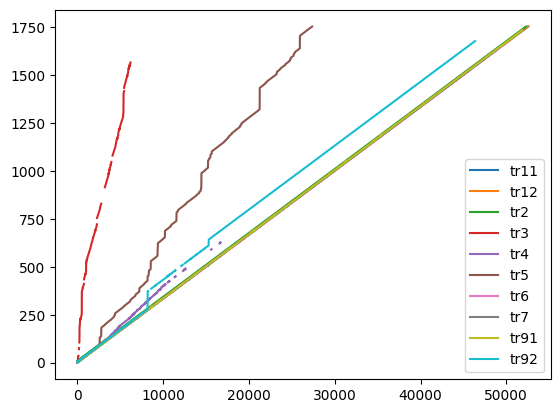

In [14]:
# Look at time steps
for k, df in dfs_dict.items(): 
    dat_times = np.asarray(df['time'].values.tolist())
    plt.plot(dat_times, label=k)
plt.legend()
plt.show()

# We can see, that some trajectories are short, with many Nans and time jumps
# [tr91,tr2,tr12,tr11, tr6, tr7] - normal; [tr92] - almost normal;
# [tr3, tr5, ] - are bad; [tr4] - totaly bad, drop it

In [9]:
# del dfs_dict['tr4'] 
# dfs_dict.keys()

dict_keys(['tr11', 'tr12', 'tr2', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92'])

for:  tr11
Unique:  [0.033 0.034]
Counts:  [33292 19275]
---------------
for:  tr12
Unique:  [0.033 0.034 0.1   1.401]
Counts:  [33261 19258     2     1]
---------------
for:  tr2
Unique:  [0.033 0.034]
Counts:  [33121 19176]
---------------
for:  tr3
Unique:  [  0.133   0.134   0.266   0.267   0.4     0.401   0.533   0.534   0.667
   0.668   0.8     0.801   0.934   0.935   1.067   1.068   1.201   1.202
   1.334   1.335   1.468   1.601   1.602   1.735   1.736   1.868   1.869
   2.002   2.135   2.268   2.269   2.402   2.536   2.803   2.937   3.069
   3.203   3.47    4.138   4.404   4.538   4.671   4.672   5.338   6.406
   7.475  12.412  13.213  14.681  25.225  46.313  53.921 103.97  116.25
     nan]
Counts:  [2816 2472    1   18   13   15    1   10    9    2    4    6    5    2
    1    1    4    2    1    1    2    3    2    3    1    1    1    4
    1    1    1    1    3    4    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1  764]
---

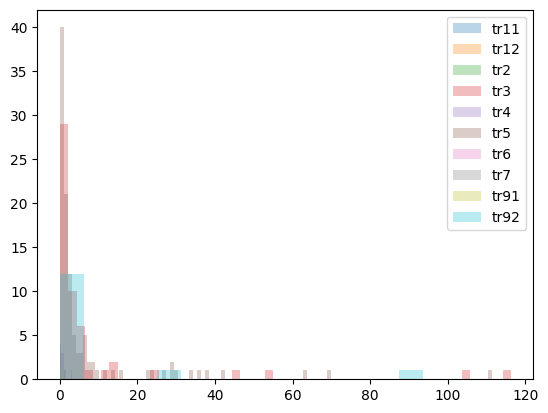

In [15]:
# Find hyperparameters for dt for each trajectory

for k, df in dfs_dict.items(): 
    dat_times = np.asarray(df['time'].values.tolist())
    dat_dt_times = np.diff(dat_times)

    uniq_dt, counts = np.unique(dat_dt_times.round(3), return_counts=True)

    plt.hist(uniq_dt, bins=uniq_dt.shape[0], label=k, alpha=0.3)
    print('for: ', k)
    print('Unique: ', uniq_dt)
    print('Counts: ', counts)
    print('-'*15)
plt.legend()
plt.show()

# tr11: 0.034, no outliers;
# tr12: 0.034, 3  outliers;
# tr2 : 0.034, no outliers;

# tr3 : 0.134, many nans and outliers, (high minimal sampling rate!);
# tr5 : 0.034, no nans and small outliers;
# tr6 : 0.034, no outliers, a lot of nans;
# tr7 : 0.034, no outliers, a lot of nans;
# tr91: 0.034, outliers, a lot of nans;
# tr92: 0.034, outliers, a lot of nans;

dt_threshold = 0.035  # dt values differnce that we count as normal (e.g. 0.133 and 0.134)

In [13]:
# Divide trajectory in sub-trajectories
traj_drop_threshold = 5

dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135, 'tr5': 0.035, # TODO: to configs
                 'tr6': 0.035, 'tr7': 0.035, 'tr91': 0.035, 'tr92': 0.035}
dfs_dict_with_subtraj = {}

for k, df in dfs_dict.items():

    # 1. Drop Nans
    df = df.dropna()

    # 2. Divide by time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.

    div_idx = np.where(dt_times > dt_thresholds[k])[0]
    div_idx = np.asarray(div_idx)

    print(k, 'div_idx: ', div_idx, len(div_idx))

    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]), div_idx, np.array([len(df)])])

        sub_trajectories = []

        start_i = div_idx[0]
        for end_i in div_idx[1:]:

            # print(start_i, end_i)
            if end_i - start_i > traj_drop_threshold:

                sub_df = df[start_i:end_i]
                # print('YES: ', sub_df.shape)
                sub_trajectories.append(sub_df)

            start_i = end_i + 1

        print('sub_trajectories len: ', len(sub_trajectories))

        dfs_dict_with_subtraj[k] = sub_trajectories
    else:
        dfs_dict_with_subtraj[k] = df

    print('--'*30)

tr11 div_idx:  [] 0
------------------------------------------------------------
tr12 div_idx:  [22542 45421 45525] 3
sub_trajectories len:  4
------------------------------------------------------------
tr2 div_idx:  [] 0
------------------------------------------------------------
tr3 div_idx:  [  58   59   69   72   77  119  120  138  140  141  143  144  156  158
  197  199  200  202  203  207  212  214  263  283  314  336  340  385
  394  422  431  441  444  488  531  541  559  605  613  681  682  684
  718  724  769  770  807  831  910  913  922  943 1004 1006 1007 1050
 1155 1168 1173 1176 1223 1406 1410 1474 1492 1501 1522 1646 1647 1650
 1688 1709 1754 1892 1956 1960 1967 2109 2116 2120 2146 2262 2294 2485
 2497 2521 2605 2606 2642 2645 2652 2737 2781 2782 2876 2877 2971 3028
 3031 3041 3047 3049 3068 3086 3097 3131 3177 3197 3203 3240 3284 3335
 3342 3343 3392 3396 3397 3598 3606 3617 3739 3749 3752 3755 3765 3766
 3768 3804 3813 3902 3924 3927 3931 3999 4055 4073 4109 4176 41

112


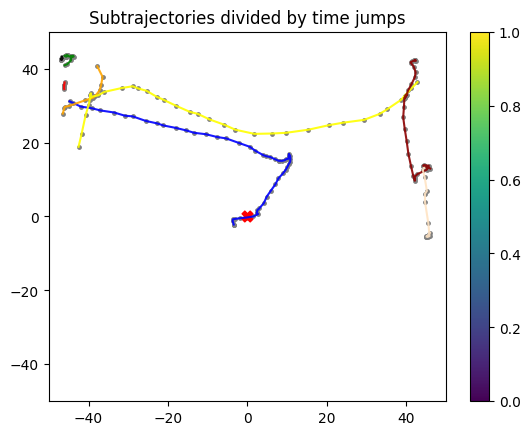

In [15]:
print(len(dfs_dict_with_subtraj['tr3']))

lines_colors = ['blue', 'red', 'green', 'black', 'orange',
                'yellow', 'darkred', 'bisque']
for i, sub_traj in enumerate(dfs_dict_with_subtraj['tr3']):
    x, y = sub_traj['x'], sub_traj['y']
    time_cmap = np.arange(0, len(x))
    plt.scatter(x, y, s=6, c='gray')
    plt.plot(x, y, alpha=0.9, c=lines_colors[i])

    if i > 6:
        break

plt.scatter(0, 0, marker='X', s=60, c='red')
plt.colorbar()
plt.xlim([-50, 50])
plt.ylim([-50, 50])
plt.title('Subtrajectories divided by time jumps')
plt.show()


In [16]:
## 2. Create function:
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # 3. Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, df

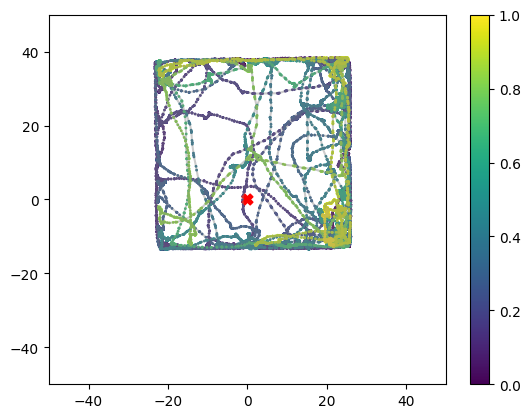

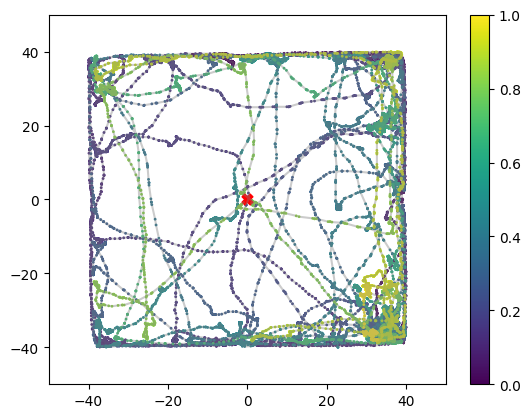

In [17]:
# 2.2. Rescale x and y coordinates to fit fixed area size
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

dff = dfs_dict['tr2'].copy()

plot_trajectory(dff['x'], dff['y'])
new_x = rescale_coord(dff['x'].to_numpy(), -40, 40)
new_y = rescale_coord(dff['y'].to_numpy(), -40, 40)

dff['x'] = new_x
dff['y'] = new_y
plot_trajectory(dff['x'], dff['y'])

In [40]:
# 3. Make resampling function, place it before all other functions, use after def divide_traj_by_nans()
import numpy as np
from scipy.signal import resample

def resample_data_to_larger_timestep(df, original_dt, new_dt):
    num_original_points = df.shape[0]
    duration = num_original_points * original_dt
    num_new_points = int(duration / new_dt)
    
    # Resample the data uresamplesing Fourier method
    resampled_dfnp = resample(df.to_numpy(), num_new_points, axis=0)
    resampled_df = pd.DataFrame({'time': resampled_dfnp[:, 0],
                                 'x': resampled_dfnp[:, 1], 
                                 'y': resampled_dfnp[:, 2]})
    return resampled_df


original_timestep = 0.034

# New desired larger dt
newdt = 0.3
dff = dfs_dict['tr11'].copy()
print('Old shape: ', dff.shape)

resampled_dat = resample_data_to_larger_timestep(dff, original_timestep, newdt)
resampled_dat.shape

Old shape:  (52568, 3)


(5957, 3)

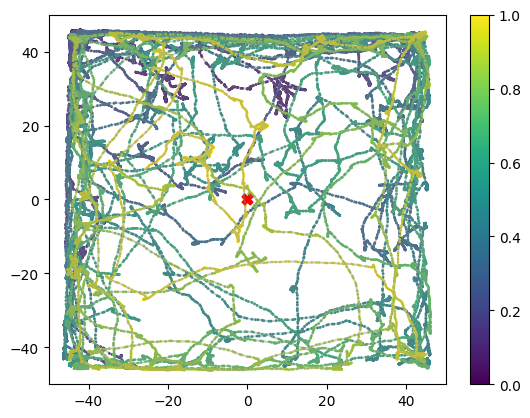

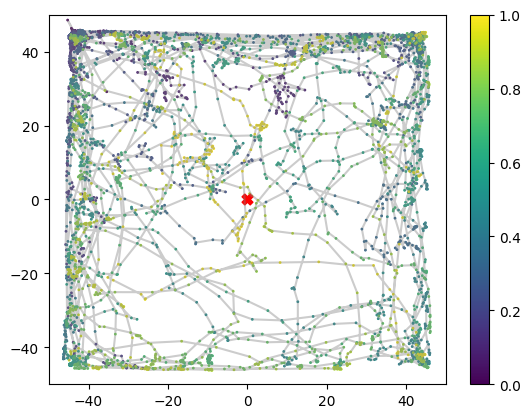

In [42]:
plot_trajectory(dff['x'], dff['y'])
plot_trajectory(resampled_dat['x'], resampled_dat['y'])

In [ ]:
# 4. Find and put into one place all functinos that add new columns to dataframe (angle, dangle, area, etc.)


In [ ]:
# 5. Save all preprocessed datasets to work with them further!



In [ ]:
# 6. Think how all other functions will operate with new data format

In [ ]:
####### STOPED HERE -===================================================
# ======================================================================
# data preproc ()
# -> 1st norebook fix 
# -> 2nd notebook fix 

# resmaple function
# re-area bounds function
#

In [ ]:
def save_preprocessed_data():  # TODO
    pass